# 1. Modules

## 1.1. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../../..')

## 1.2. Load library modules

In [3]:
import torch
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator, HeightContinuationPadder, ZeroPadder, WidthContinuationPadder
import numpy as np

from IPython.display import display, clear_output

from magrec import __datapath__
from magrec.misc.load import load_matlab_data
from magrec.misc.plot import plot_n_components

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

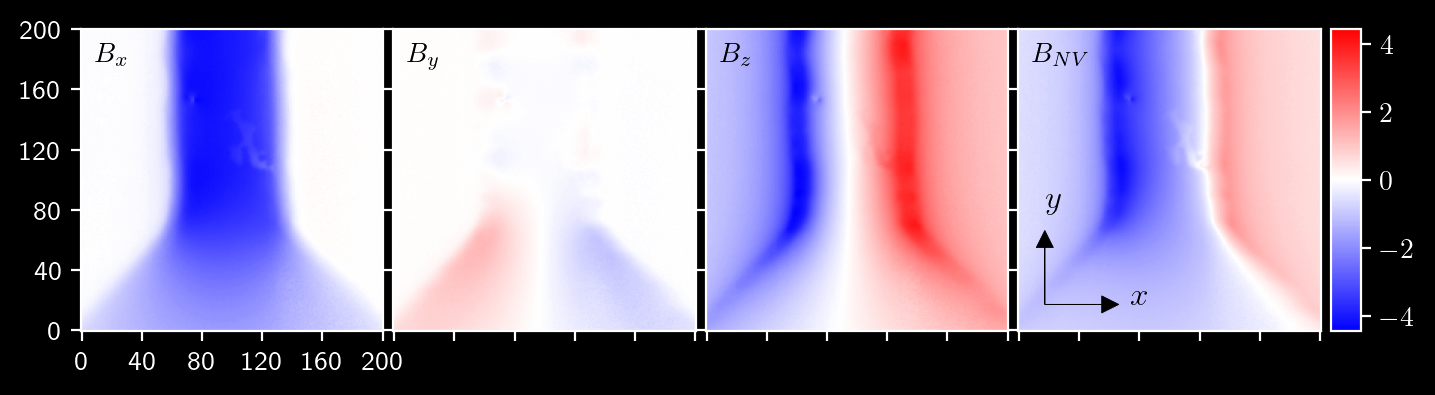

In [4]:
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = np.empty(shape=(4, 201, 201))

setTheta = np.deg2rad(54.7)
setPhi = np.deg2rad(45)

unv = [np.sin(setTheta) * np.cos(setPhi),
       np.sin(setTheta) * np.sin(setPhi),
       np.cos(setTheta)]

B[0, :, :] = np.flipud(Bx)
B[1, :, :] = np.flipud(By)
B[2, :, :] = np.flipud(Bz)
B[3, :, :] = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

plot_n_components(B, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr", show=True)

# Trim B to 200 × 200 so that FFT deals with even dimensions
B = B[:, :200, :200]

## 2.2. Define parameters

In [5]:
dx=0.408  # in μm
dy=0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30.0              # degrees

# 3. Current reconstruction

## 3.1. Define J → B transformation

In [6]:

shape = (2, 200, 200)
pad1 = HeightContinuationPadder(shape=shape)
pad2 = ZeroPadder(shape=pad1.expanded_shape)
propagator = CurrentPropagator2d(source_shape=pad2.expanded_shape,
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)
proj = AxisProjectionPropagator(theta=theta, phi=phi)


def compute_B_NV(J: torch.tensor):
    J = pad1.pad(J)
    J = pad2.pad(J)
    B = propagator(J)
    B = pad2.unpad(B)
    B = pad1.unpad(B)
    B_NV = proj.project(B)
    B = torch.stack([B[0], B[1], B[2], B_NV], dim=0)
    return B


## 3.2. Check the work of the J → B transformation

To see on an example what `compute_B_NV` does, let's set up a simple current distribution with a constant current along y-axis with only J_y component, and output the resultant magnetic field.

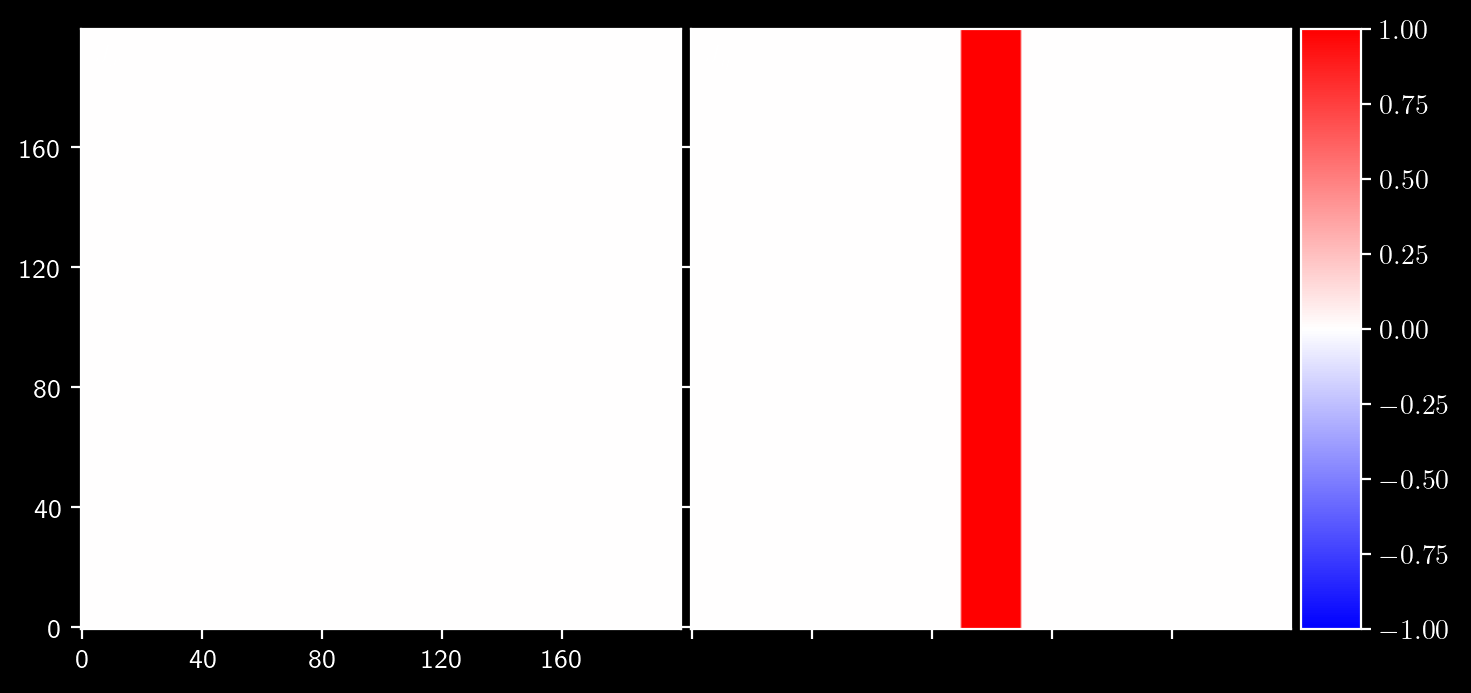

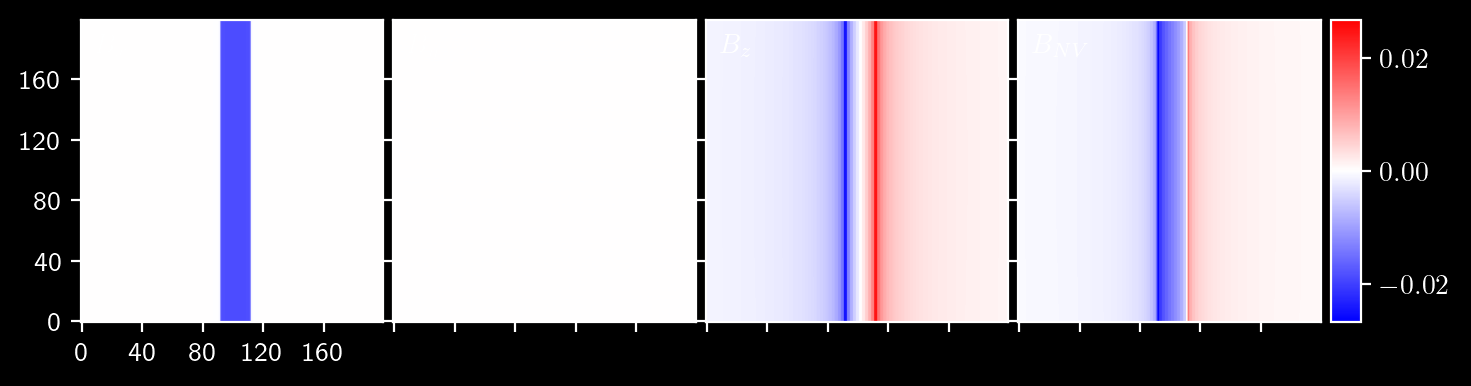

In [16]:
J_example = torch.zeros(size=(2, 200, 200))
J_example[1, 90:110, :] = 1.0

B_example = compute_B_NV(J_example)
plot_n_components(B_example, labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr", show=True)
plot_n_components(J_example, labels=[r'$J_x$', '$J_y$'], cmap="bwr")

## 3.3. Define optimizer, loss function and training loop

### 3.3.1. Optimization on $B_{NV}$ only

In [7]:
# Here we define the loss function and the optimization algorithm
def run_optimization(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop.
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the current density to optimize for
    J = torch.zeros(size=(2, 200, 200), requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = compute_B_NV(J)
        
        # Compute the loss
        loss = loss_fn(B_pred[3], B[3])
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}")
            fig1 = plot_n_components(J.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-9:
                print('Changing learning rate to 1e-1')
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1

            if loss.item() < 1e-11:
                print('Changing learning rate to 1e-3')
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            
            # If the loss is small enough, stop the optimization
            if loss.item() < 1e-13:
                print('Stopping optimization, converged to a loss of < 1e-10')
                break

    return J

Some info from experiments with running the function above with some parameters:

1. Loss of ≈0.79 corresponds to a not satisfactory result. This loss is achieved in about 3m when learning rate of 1e-1 is used 

Loss at iteration 9900: 6.5380895364342e-08


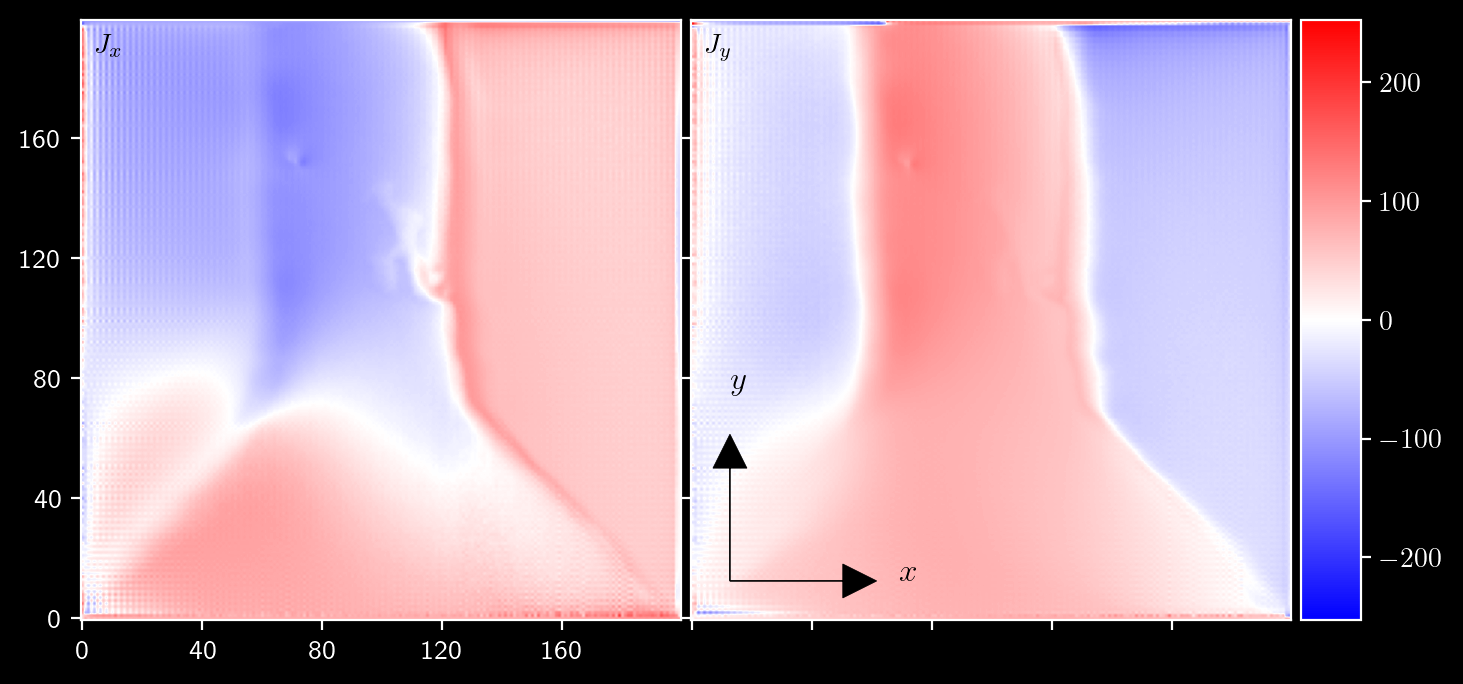

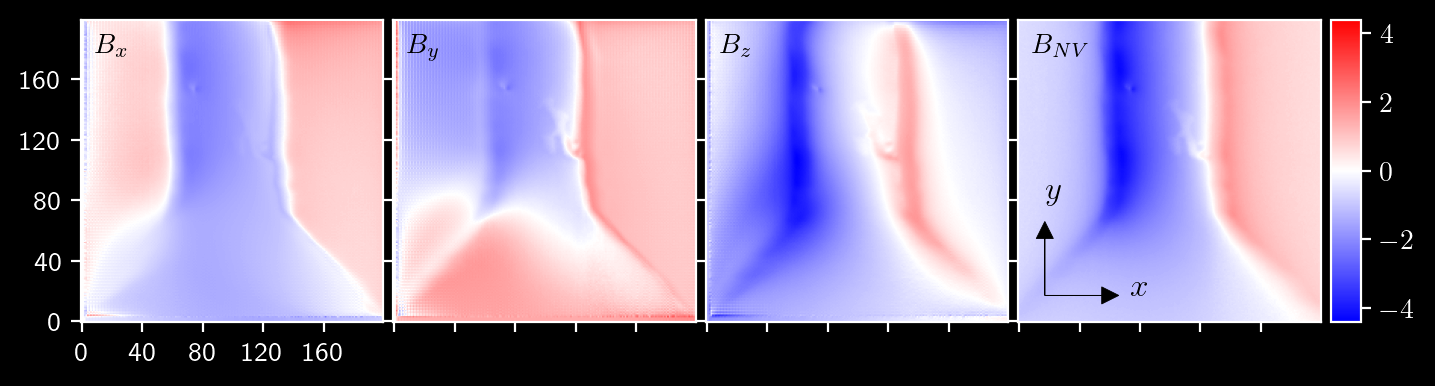

In [8]:
J = run_optimization(B, 10000, 100)

### 3.3.2. Optimization on three components of $B$

The next thing to try is to use all $B$ components for reconstruction. We will define a new function and see how it works:

In [ ]:
def run_optimization_on_three_components(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop using all three components of B (and B_NV too)
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the current density to optimize for
    J = torch.zeros(size=(2, 200, 200), requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = compute_B_NV(J)
        
        # Compute the loss
        loss = loss_fn(B_pred, B)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}")
            fig1 = plot_n_components(J.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-8:
                print('Changing learning rate to 1e-1')
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1

            if loss.item() < 1e-10:
                print('Changing learning rate to 1e-3')
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            
            # If the loss is small enough, stop the optimization
            if loss.item() < 1e-10:
                print('Stopping optimization, converged to a loss of < 1e-10')
                break

    return J

Loss at iteration 1900: 0.011223074048757553


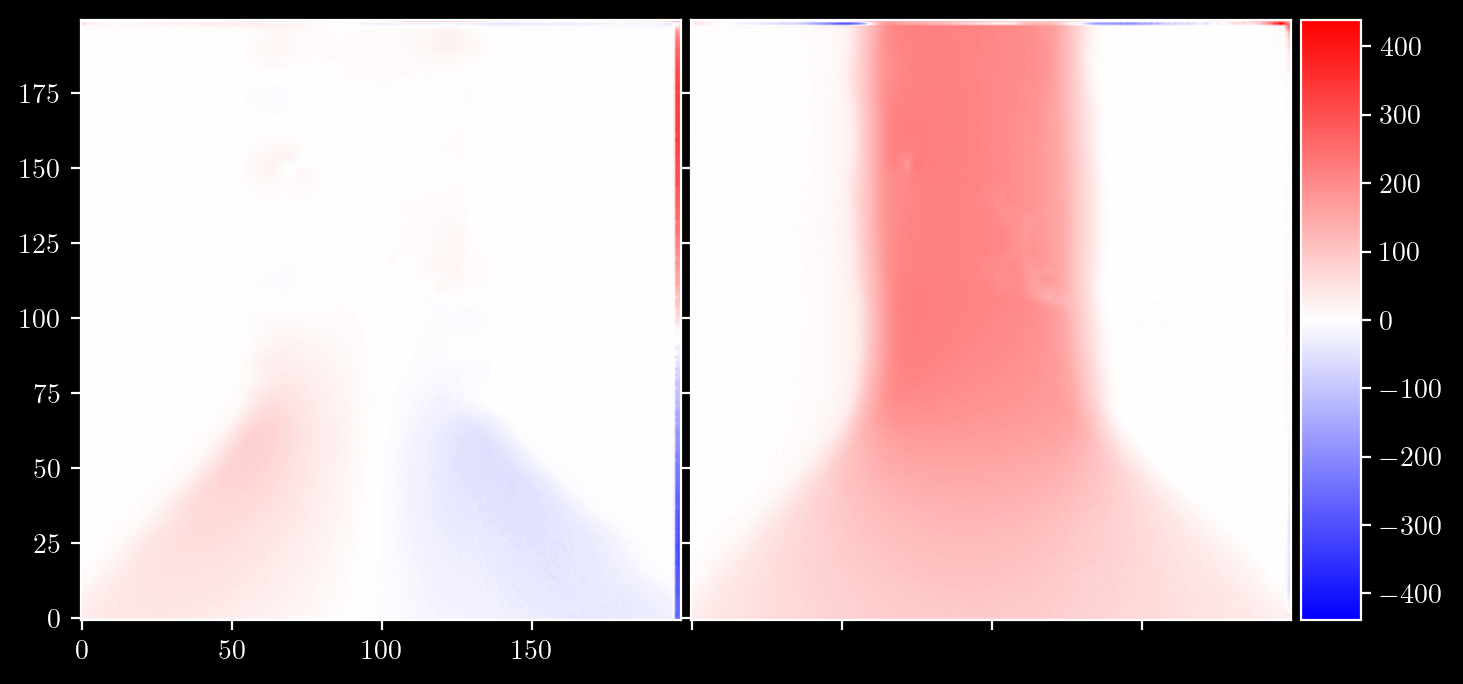

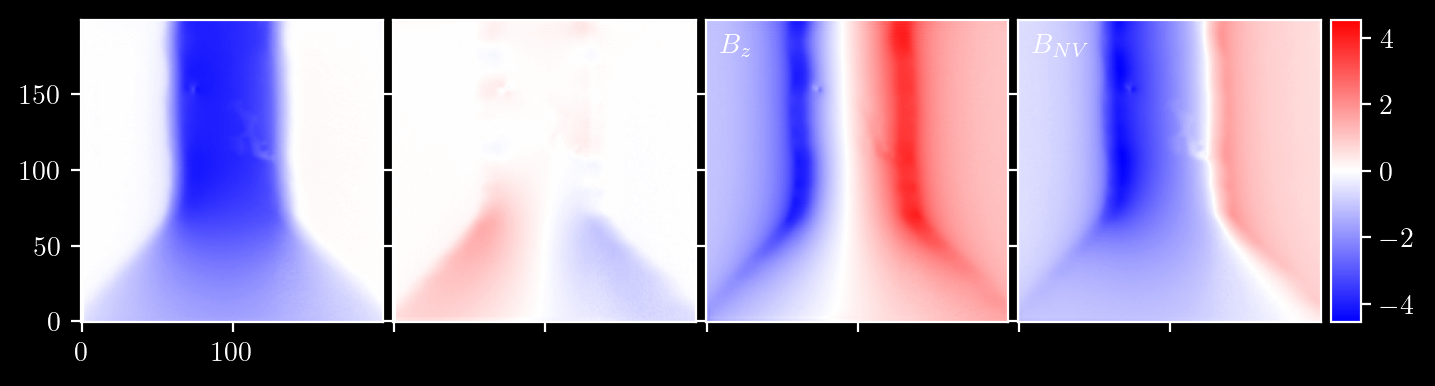

In [ ]:
J_from_three_components = run_optimization_on_three_components(B, 2000, 100)

### 3.3.3. Optimization with replication padding

In [42]:
# Rewrite `compute_B_NV` to use WidthContinuationPadder instead of the zero padding on the sides.

W, H = B.shape[-2:]
pad_repl = torch.nn.ReplicationPad2d((W, W, H, H))
pad_zero = torch.nn.ZeroPad2d((W, W, H, H))
propagator = CurrentPropagator2d(source_shape=(2, 5*W, 5*H),
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

def compute_B_with_repl(J: torch.tensor):
    J = pad_repl(J)
    J = pad_zero(J)
    B = propagator(J)
    B = B[..., 2*W:-2*W, 2*H:-2*H]
    B_NV = proj.project(B)
    # That's a more general stacking to allow for batch dimension
    B = torch.stack([B[..., -3, :, :], 
                     B[..., -2, :, :], 
                     B[..., -1, :, :], 
                  B_NV[..., :, :]], 
                     dim=-3)
    return B

def run_optimization_repl(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop using all three components of B (and B_NV too)
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the current density to optimize for
    J = torch.zeros(size=(2, 200, 200), requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = compute_B_with_repl(J)
        
        # Compute the loss
        loss = loss_fn(B_pred, B)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}")
            fig1 = plot_n_components(J.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-8:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1
            elif loss.item() < 1e-10:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.
            
            # If the loss is small enough, stop the optimization
            if loss.item() < 1e-10:
                print('Stopping optimization, converged to a loss of < 1e-10')
                break

    return J

Loss at iteration 1900: 0.011660966090857983


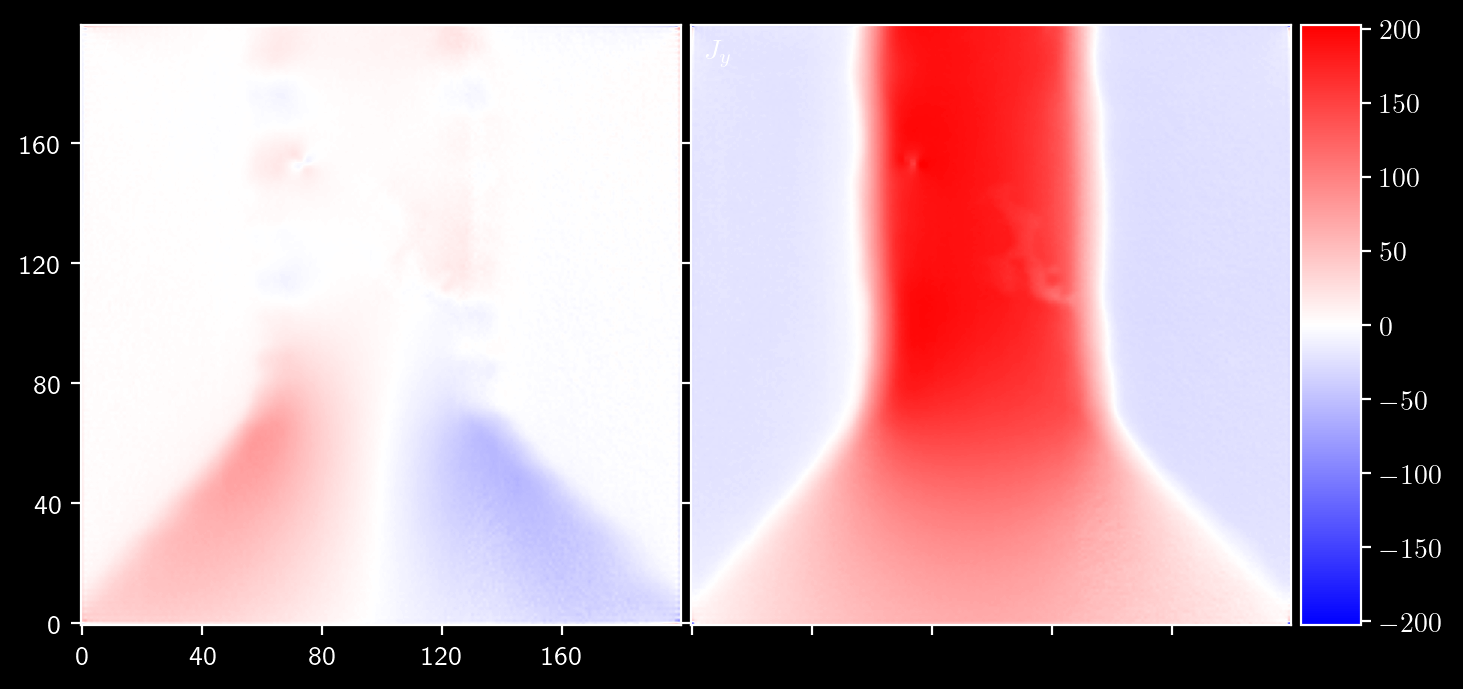

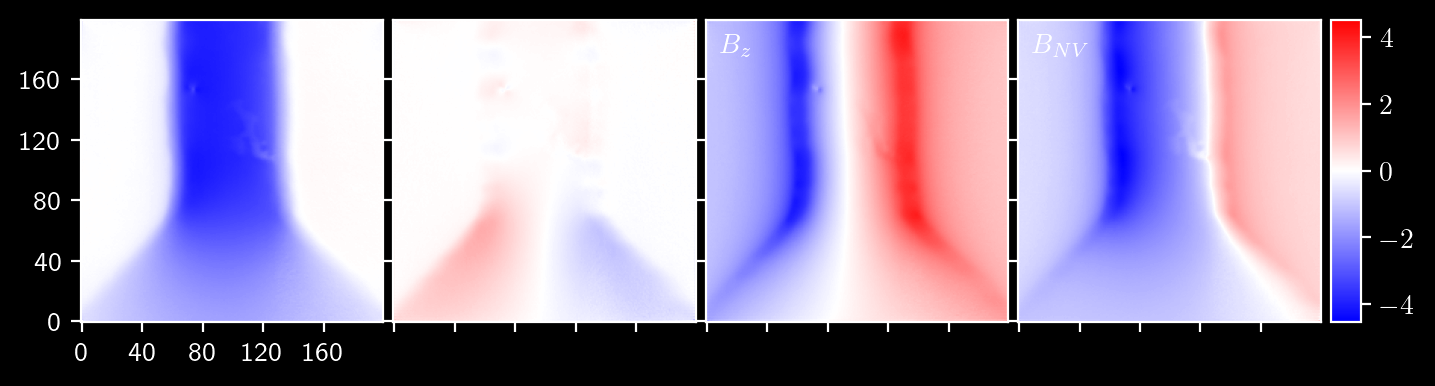

In [43]:
J_from_both_sides_padded = run_optimization_repl(B, 2000, 100)

### 3.3.4. Optimization with only one component of B

In [39]:
def run_optimization_repl_B_NV(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop using all three components of B (and B_NV too)
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the current density to optimize for
    J = torch.zeros(size=(2, 200, 200), requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = compute_B_with_repl(J)
        
        # Compute the loss
        loss = loss_fn(B_pred[..., -1, :, :], B[..., -1, :, :])
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}")
            fig1 = plot_n_components(J.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-8:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1
            elif loss.item() < 1e-10:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.
            
            # If the loss is small enough, stop the optimization
            if loss.item() < 1e-10:
                print('Stopping optimization, converged to a loss of < 1e-10')
                break

    return J

Loss at iteration 1900: 6.311749984888593e-07


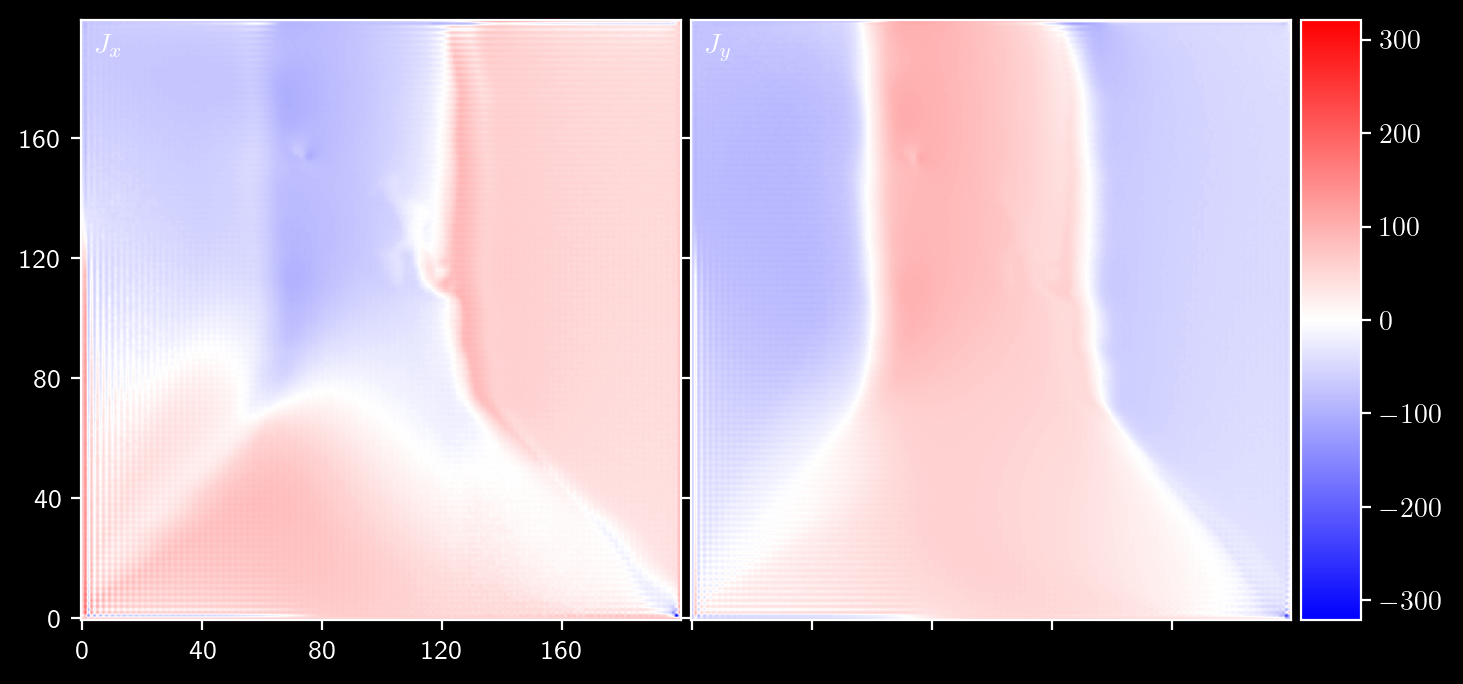

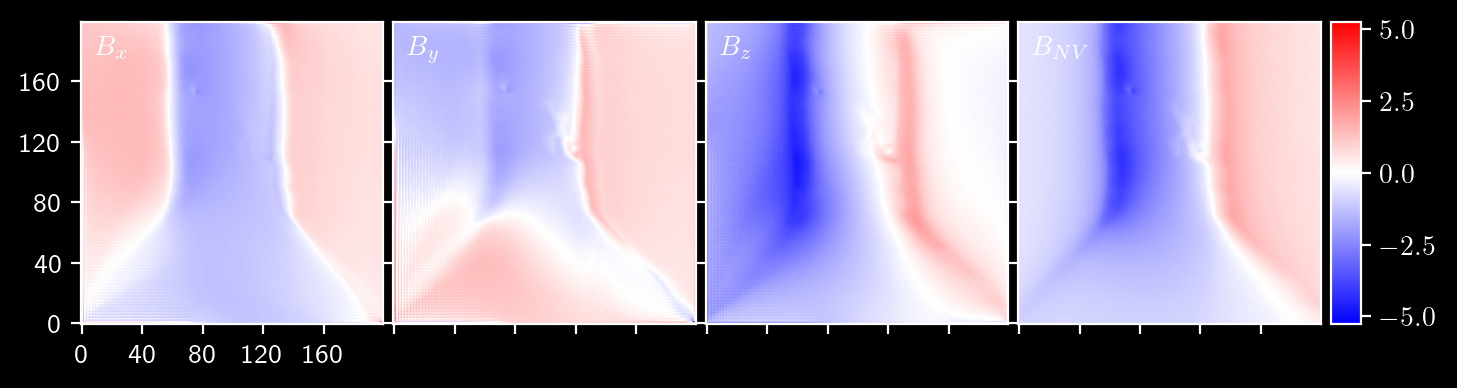

In [40]:
J = run_optimization_repl_B_NV(B, 2000, 100)

## 3.4. Define optimization with preserved quantities

In [57]:
# J is a tensor with boundary conditions enforced on the boundary of the domain
# Start with enforcing J_y component to integrate to a constant value which is also to be optimized

def compute_B_with_preserved_J_y(J_x, J_y, J_y_int=0.):
    """Compute the magnetic field with the integral of J_y component preserved
    
    Parameters
    ----------
    J_x : torch.tensor
        The x component of the current density

    J_y : torch.tensor
        The y component of the current density

    J_y_int : float, optional
        The integral of J_y to preserve, by default 0.

    Returns
    -------
    B : torch.tensor
        The magnetic field
    """
    # Compute the the boundary column based on condition that J_y integrates to J_y_int
    J_y_boundary = J_y_int - J_y.sum(dim=-2)

    # Add the boundary column to J_y
    J_y = torch.cat([J_y, J_y_boundary[..., None, :]], dim=-2)

    # Combine J_x and J_y into a single tensor
    J = torch.stack([J_x, J_y], dim=-3)

    J = pad_repl(J)
    J = pad_zero(J)
    B = propagator(J)
    B = B[..., 2*W:-2*W, 2*H:-2*H]
    B_NV = proj.project(B)
    # That's a more general stacking to allow for batch dimension
    B = torch.stack([B[..., -3, :, :], 
                     B[..., -2, :, :], 
                     B[..., -1, :, :], 
                  B_NV[..., :, :]], 
                     dim=-3)
    return B, J


def run_optimization_preserve(B, n_iter=1000, plot_interval=100):
    """Run the optimization loop using all three components of B (and B_NV too)
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """
    # Initialize the tensor to optimize for: J_x, J_y, J_y_int
    J_x = torch.zeros(size=(1, 200, 200), requires_grad=True)
    J_y = torch.zeros(size=(1, 199, 200), requires_grad=True)
    J_y_int = torch.tensor([200.], requires_grad=True)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer([J_x, J_y, J_y_int], lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred, J_pred = compute_B_with_preserved_J_y(J_x, J_y, J_y_int)
        
        # Compute the loss
        loss = loss_fn(B_pred[..., -1, :, :], B[..., -1, :, :])
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            print(f"Loss at iteration {i}: {loss.item()}\n")
            print(f"J_y_int: {J_y_int}\n")
            fig1 = plot_n_components(J_pred.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
            fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

            # Display the output in the notebook and clear the output
            display(fig1)
            display(fig2)
            clear_output(wait=True)

            # If the loss is smaller then this value, change the learning rate
            if loss.item() < 1e-8:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-1
            elif loss.item() < 1e-10:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1e-3
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.
            
            # If the loss is small enough, stop the optimization
            if loss.item() < 1e-10:
                print('Stopping optimization, converged to a loss of < 1e-10')
                break

    display(fig1, fig2)
    return J_pred
    

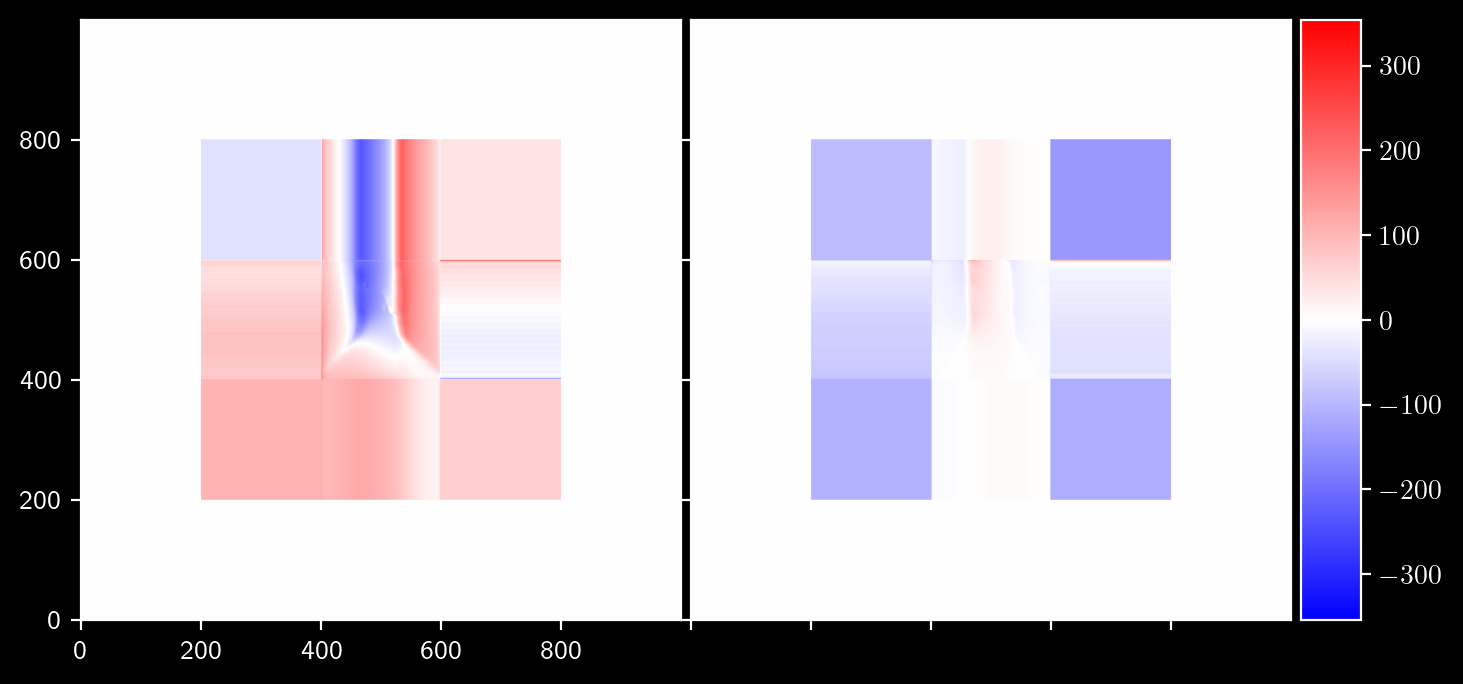

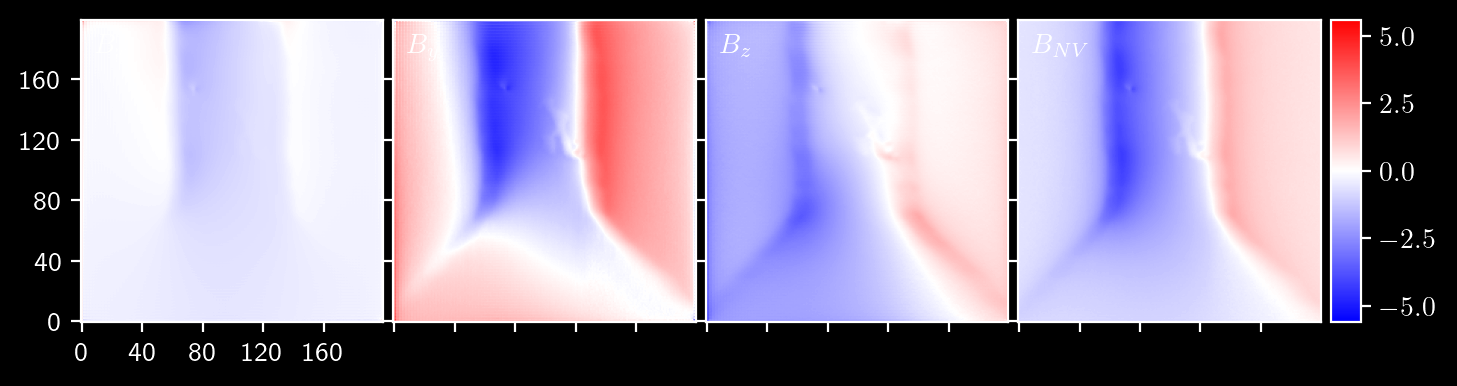

In [58]:
J = run_optimization_preserve(B, 2000, 100)

In [59]:
J_window = J[..., 2*W:-2*W, 2*H:-2*H]

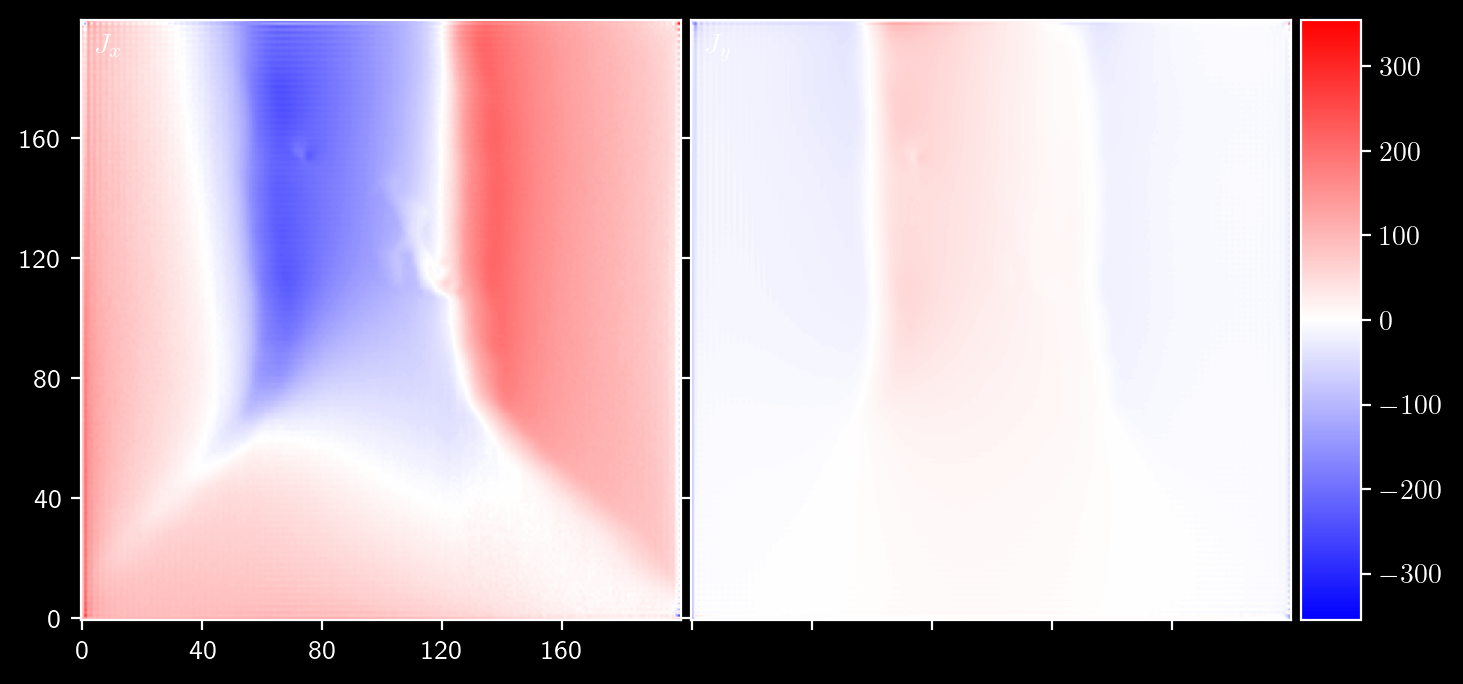

In [60]:
plot_n_components(J_window.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")